In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import subprocess
from pathlib import Path as p
import numpy as np
plt.close('all')

In [3]:
path = p().resolve()
p(path, 'inputs', 'insert').mkdir(parents=True, exist_ok=True)
p(path, 'inputs', 'start_remove').mkdir(parents=True, exist_ok=True)
p(path, 'inputs', 'end_remove').mkdir(parents=True, exist_ok=True)
p(path, 'outputs', 'insert').mkdir(parents=True, exist_ok=True)
p(path, 'outputs', 'start_remove').mkdir(parents=True, exist_ok=True)
p(path, 'outputs', 'end_remove').mkdir(parents=True, exist_ok=True)

In [59]:
def compile_scripts():
    if not p(path, 'build').is_dir():
        subprocess.run(
            [
                '/usr/bin/cmake', 
                '--no-warn-unused-cli', 
                '-DCMAKE_EXPORT_COMPILE_COMMANDS:BOOL=TRUE', 
                '-DCMAKE_BUILD_TYPE:STRING=Debug', 
                '-DCMAKE_C_COMPILER:FILEPATH=/usr/bin/gcc', 
                '-DCMAKE_CXX_COMPILER:FILEPATH=/usr/bin/g++', 
                '-S',
                path, 
                '-B',
                p(path, 'build'), 
                '-G', 
                'Ninja'
            ]
        )
    subprocess.run(
        [
            '/usr/bin/cmake',
            '--build',
            p(path, 'build'), 
            '--config', 
            'Debug', 
            '--target',
            'all', 
            '--'
        ]
    )
    
def generate_inputs(path, size):
    with open(p(path, 'insert', 'worst_case.in'), 'w') as insert:
        with open(p(path, 'start_remove', 'worst_case.in'), 'w') as start_remove:
            with open(p(path, 'end_remove', 'worst_case.in'), 'w') as end_remove:
                nums = list(range(1, size + 1))
                for num in nums:
                    insert.write(f'1 {num} 3\n')
                    start_remove.write(f'1 {num}\n')
                    end_remove.write(f'1 {num}\n')
                for num in nums:
                    start_remove.write(f'2 {num} 3\n')
                for num in reversed(nums):
                    end_remove.write(f'2 {num} 3\n')
                insert.write('0\n')
                start_remove.write('0\n')
                end_remove.write('0\n')
    with open(p(path, 'insert', 'average_case.in'), 'w') as insert:
        with open(p(path, 'start_remove', 'average_case.in'), 'w') as start_remove:
            with open(p(path, 'end_remove', 'average_case.in'), 'w') as end_remove:
                nums = np.random.permutation(size + 1)
                for num in nums:
                    insert.write(f'1 {num} 3\n')
                    start_remove.write(f'1 {num}\n')
                    end_remove.write(f'1 {num}\n')
                for num in nums:
                    start_remove.write(f'2 {num} 3\n')
                for num in reversed(nums):
                    end_remove.write(f'2 {num} 3\n')
                insert.write('0\n')
                start_remove.write('0\n')
                end_remove.write('0\n')
    with open(p(path, 'insert', 'best_case.in'), 'w') as insert:
        with open(p(path, 'start_remove', 'best_case.in'), 'w') as start_remove:
            with open(p(path, 'end_remove', 'best_case.in'), 'w') as end_remove:
                result = []
                div = 2
                for _ in range(20):
                    result.extend(round(mul * size / div) for mul in range(1, div, 2))
                    div *= 2
                result = list(dict.fromkeys(result))
                for num in result:
                    insert.write(f'1 {num} 3\n')
                    start_remove.write(f'1 {num}\n')
                    end_remove.write(f'1 {num}\n')
                for num in result:
                    start_remove.write(f'2 {num} 3\n')
                for num in reversed(result):
                    end_remove.write(f'2 {num} 3\n')
                insert.write('0\n')
                start_remove.write('0\n')
                end_remove.write('0\n')

def run_script(tree, input, output):
    scripts = p(path, 'build', 'scripts')
    with open(input) as input_file:
        with open(output, 'w') as output_file:
            subprocess.run(p(scripts, tree, tree), stdin=input_file, stdout=output_file)

def plot(test, case):
    data = pd.read_csv(p(path, 'outputs', test, f'bst_{case}_case.csv'), header=None).rename(columns={0: 'bst'})
    data.insert(1, 'avl', pd.read_csv(p(path, 'outputs', test, f'avl_{case}_case.csv'), header=None))
    data.insert(2, 'rb', pd.read_csv(p(path, 'outputs', test, f'rb_{case}_case.csv'), header=None))
    data *= 1000
    ax = data.plot(ylabel='Tempo de execução (milisegundos)', xlabel='Número de elementos presentes na árvore')
    ax.get_figure().savefig(p('plots', f'{test}_{case}.png'))
    ax = data.plot(ylabel='Tempo de execução (milisegundos)', xlabel='Número de elementos presentes na árvore', style='k')
    ax.plot(sm.OLS(data['bst'], sm.add_constant(list(range(len(data['bst']))))).fit().fittedvalues)
    ax.plot(sm.OLS(data['avl'], sm.add_constant(list(range(len(data['avl']))))).fit().fittedvalues)
    ax.plot(sm.OLS(data['rb'], sm.add_constant(list(range(len(data['rb']))))).fit().fittedvalues)
    ax.get_figure().savefig(p('plots', f'{test}_{case}_ols.png'))
    

In [5]:
compile_scripts()

ninja: no work to do.


In [6]:
generate_inputs(f'{path}/inputs', 100000)

In [7]:
run_script('bst', f'{path}/inputs/insert/worst_case.in', f'{path}/outputs/insert/bst_worst_case.csv')
run_script('bst', f'{path}/inputs/insert/average_case.in', f'{path}/outputs/insert/bst_average_case.csv')
run_script('bst', f'{path}/inputs/insert/best_case.in', f'{path}/outputs/insert/bst_best_case.csv')
run_script('bst', f'{path}/inputs/start_remove/worst_case.in', f'{path}/outputs/start_remove/bst_worst_case.csv')
run_script('bst', f'{path}/inputs/start_remove/average_case.in', f'{path}/outputs/start_remove/bst_average_case.csv')
run_script('bst', f'{path}/inputs/start_remove/best_case.in', f'{path}/outputs/start_remove/bst_best_case.csv')
run_script('bst', f'{path}/inputs/end_remove/worst_case.in', f'{path}/outputs/end_remove/bst_worst_case.csv')
run_script('bst', f'{path}/inputs/end_remove/average_case.in', f'{path}/outputs/end_remove/bst_average_case.csv')
run_script('bst', f'{path}/inputs/end_remove/best_case.in', f'{path}/outputs/end_remove/bst_best_case.csv')

In [8]:
run_script('avl', f'{path}/inputs/insert/worst_case.in', f'{path}/outputs/insert/avl_worst_case.csv')
run_script('avl', f'{path}/inputs/insert/average_case.in', f'{path}/outputs/insert/avl_average_case.csv')
run_script('avl', f'{path}/inputs/insert/best_case.in', f'{path}/outputs/insert/avl_best_case.csv')
run_script('avl', f'{path}/inputs/start_remove/worst_case.in', f'{path}/outputs/start_remove/avl_worst_case.csv')
run_script('avl', f'{path}/inputs/start_remove/average_case.in', f'{path}/outputs/start_remove/avl_average_case.csv')
run_script('avl', f'{path}/inputs/start_remove/best_case.in', f'{path}/outputs/start_remove/avl_best_case.csv')
run_script('avl', f'{path}/inputs/end_remove/worst_case.in', f'{path}/outputs/end_remove/avl_worst_case.csv')
run_script('avl', f'{path}/inputs/end_remove/average_case.in', f'{path}/outputs/end_remove/avl_average_case.csv')
run_script('avl', f'{path}/inputs/end_remove/best_case.in', f'{path}/outputs/end_remove/avl_best_case.csv')

In [9]:
run_script('rb', f'{path}/inputs/insert/worst_case.in', f'{path}/outputs/insert/rb_worst_case.csv')
run_script('rb', f'{path}/inputs/insert/average_case.in', f'{path}/outputs/insert/rb_average_case.csv')
run_script('rb', f'{path}/inputs/insert/best_case.in', f'{path}/outputs/insert/rb_best_case.csv')
run_script('rb', f'{path}/inputs/start_remove/worst_case.in', f'{path}/outputs/start_remove/rb_worst_case.csv')
run_script('rb', f'{path}/inputs/start_remove/average_case.in', f'{path}/outputs/start_remove/rb_average_case.csv')
run_script('rb', f'{path}/inputs/start_remove/best_case.in', f'{path}/outputs/start_remove/rb_best_case.csv')
run_script('rb', f'{path}/inputs/end_remove/worst_case.in', f'{path}/outputs/end_remove/rb_worst_case.csv')
run_script('rb', f'{path}/inputs/end_remove/average_case.in', f'{path}/outputs/end_remove/rb_average_case.csv')
run_script('rb', f'{path}/inputs/end_remove/best_case.in', f'{path}/outputs/end_remove/rb_best_case.csv')

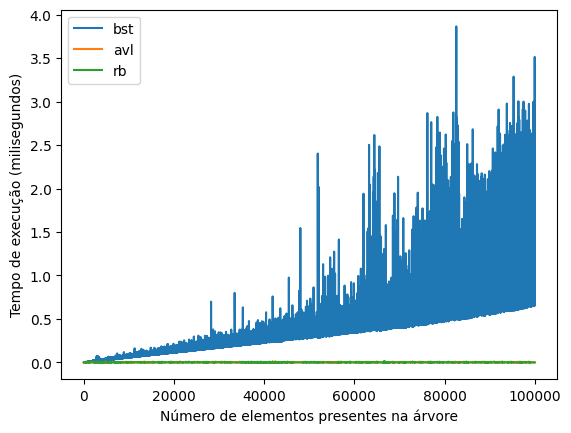

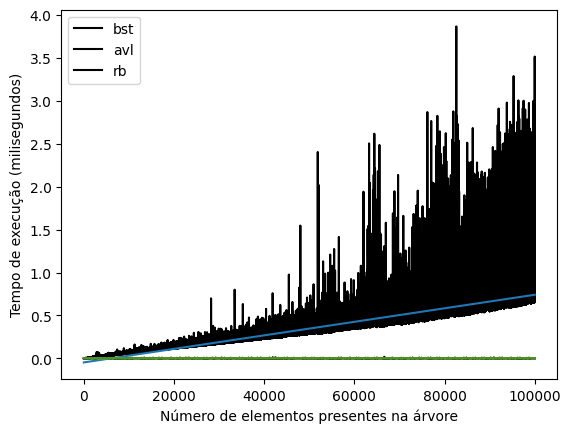

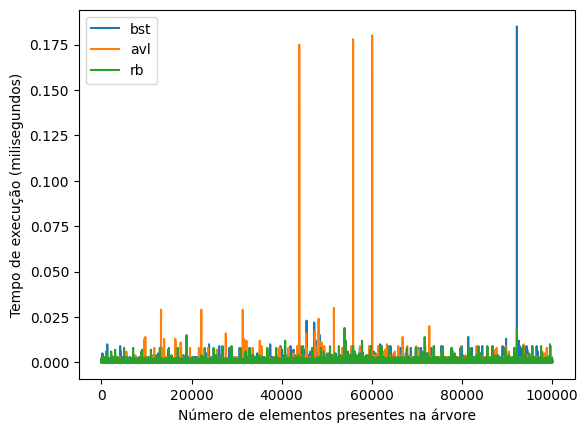

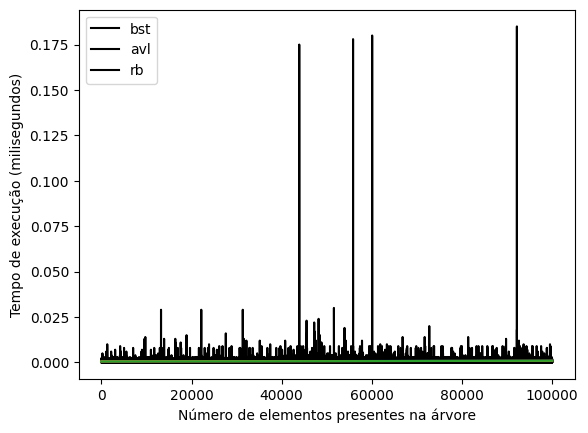

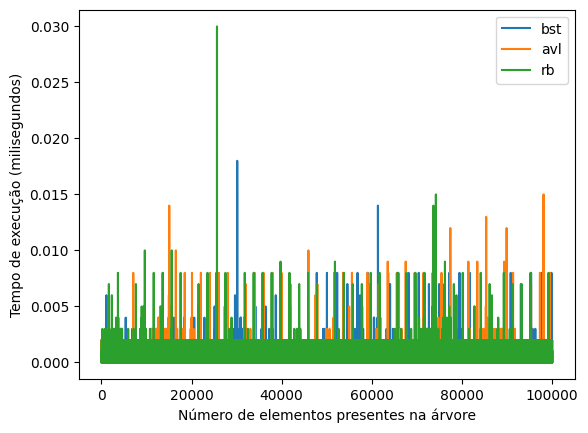

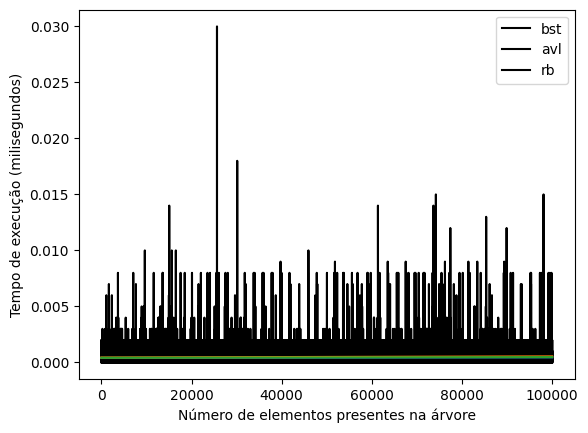

In [60]:
plot('insert', 'worst')
plot('insert', 'average')
plot('insert', 'best')

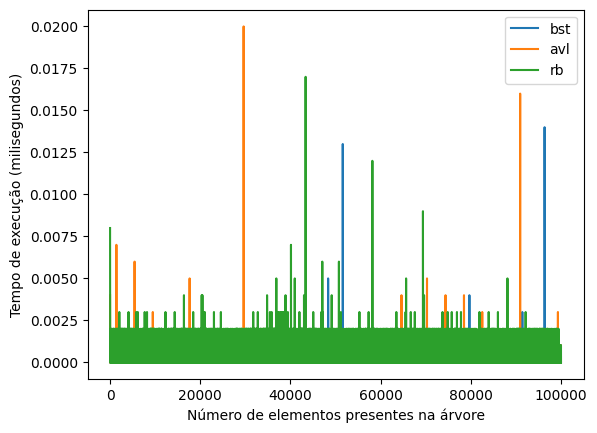

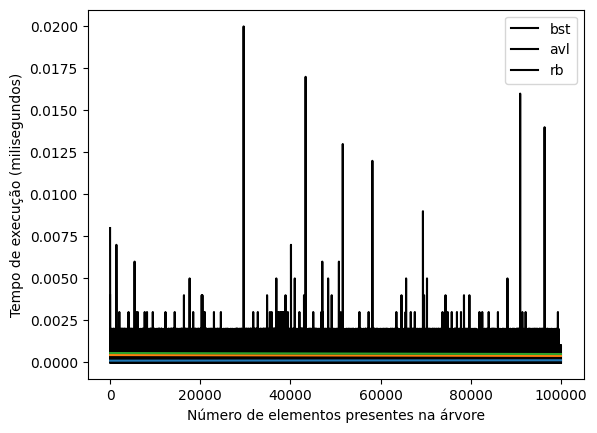

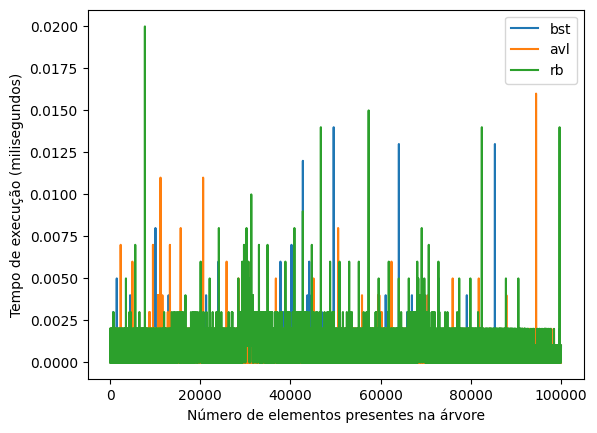

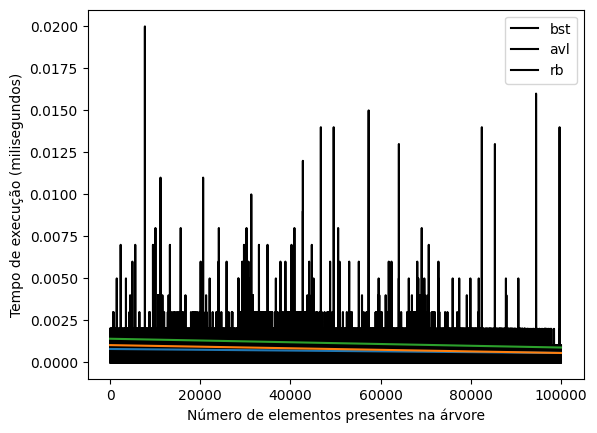

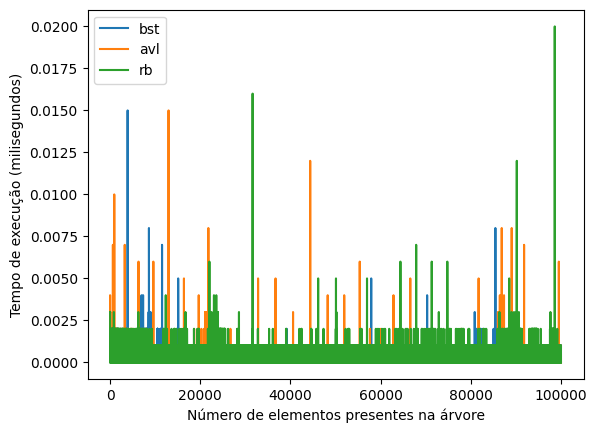

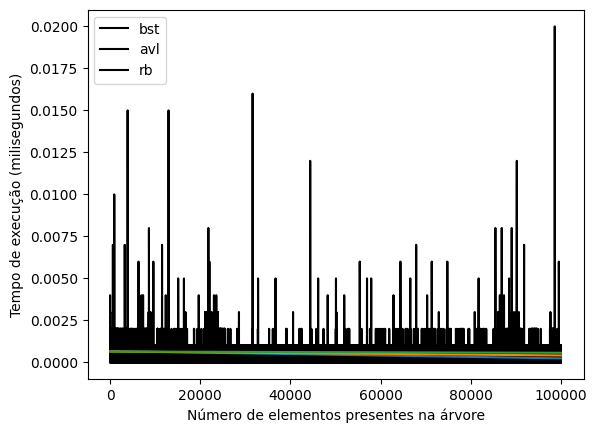

In [61]:
plot('start_remove', 'worst')
plot('start_remove', 'average')
plot('start_remove', 'best')

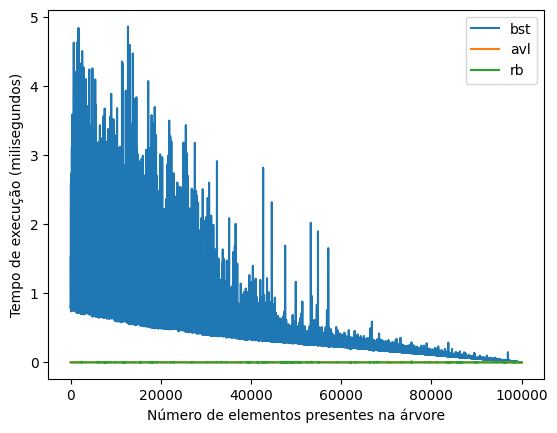

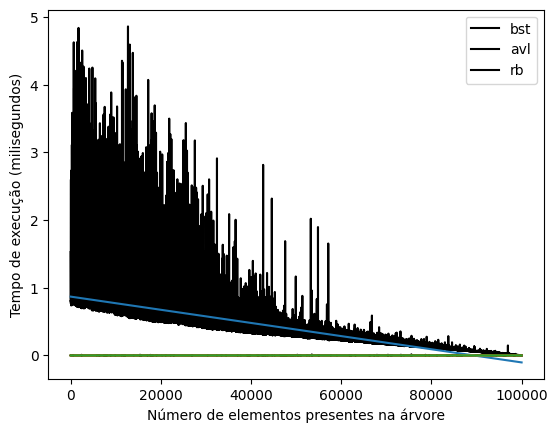

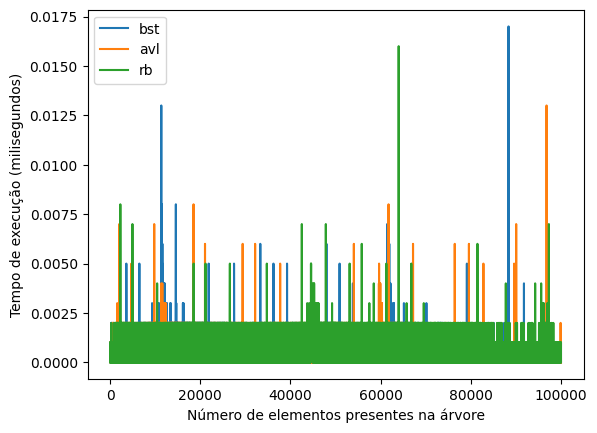

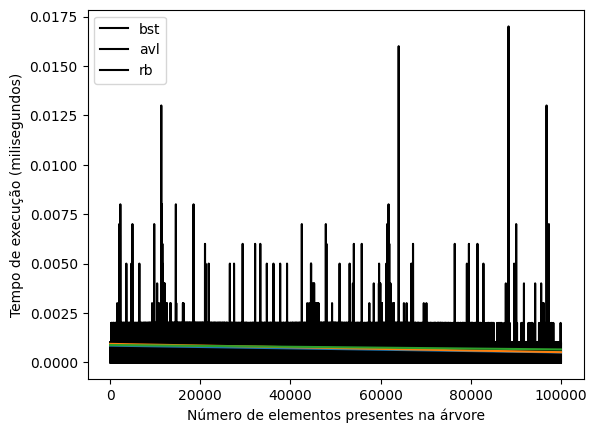

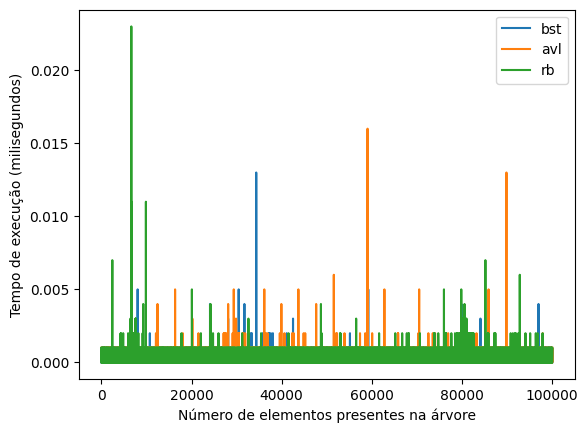

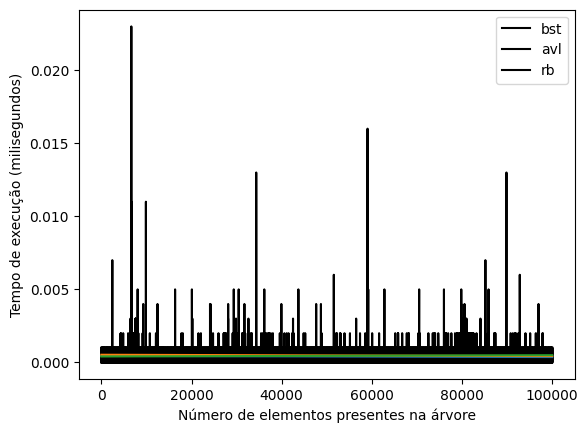

In [62]:
plot('end_remove', 'worst')
plot('end_remove', 'average')
plot('end_remove', 'best')